In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
from lime.lime_tabular import LimeTabularExplainer  
import joblib
from sklearn.preprocessing import StandardScaler

In [142]:
processed_data = pd.read_csv('processed_data.csv')

In [149]:
patient = 1
data = processed_data[processed_data['patient'] == patient]
patient = '001'

food_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

# Convert datetime to pandas datetime
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
#food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

In [160]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data.drop(columns=['datetime'])), columns=data.columns.drop('datetime'))
scaled_data['datetime'] = data['datetime'].values
scaled_data['datetime'] = pd.to_datetime(scaled_data['datetime'])
scaled_data = scaled_data.iloc[1000:1200, :]
scaled_data['meal_intake'] = 0

for idx, meal_time in food_data.iterrows():
    meal_time = meal_time['datetime']
    mask = (scaled_data['datetime'] >= meal_time - pd.Timedelta(minutes=5)) & (scaled_data['datetime'] <= meal_time)
    indices = scaled_data[mask].index
    for i in indices:
        if i >= 3 and scaled_data.loc[i-3:i-1, 'meal_intake'].sum() == 0:
            scaled_data.at[i, 'meal_intake'] = 1

In [185]:
def plot_glucose_with_meals():
    # Plot the feature over index
    plt.figure(figsize=(15, 5))

    plt.plot(scaled_data.index, scaled_data['glucose'], label='glucose', color='blue', linewidth=1.5)
    for idx, row in scaled_data.iterrows():
        if row['meal_intake'] == 1:
            plt.axvline(x=idx, color='purple', linestyle='--')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')
    plt.tight_layout()
    plt.axis('off')
    plt.savefig('paper_images/glucose_with_meals.png')
    plt.close()

In [186]:
plot_glucose_with_meals()

In [187]:
def plot_features_with_meals(features):
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'brown', 'black', 'orange']
    # Plot the feature over index
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(features):
        if feature == 'glucose':
            plt.plot(scaled_data.index, scaled_data[feature], label=feature, color=colors[i % len(colors)], linewidth=2.5)
        else:
            plt.plot(scaled_data.index, scaled_data[feature], label=feature, color=colors[i % len(colors)], alpha=0.4)

    for idx, row in scaled_data.iterrows():
        if row['meal_intake'] == 1:
            plt.axvline(x=idx, color='purple', linestyle='--')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')
    plt.tight_layout()
    plt.axis('off')
    plt.savefig('paper_images/features_with_meals.png')
    plt.close()

In [188]:
plot_features_with_meals(['glucose', 'simple_sugars', 'complex_sugars', 'proteins', 'fats', 'dietary_fibers'])

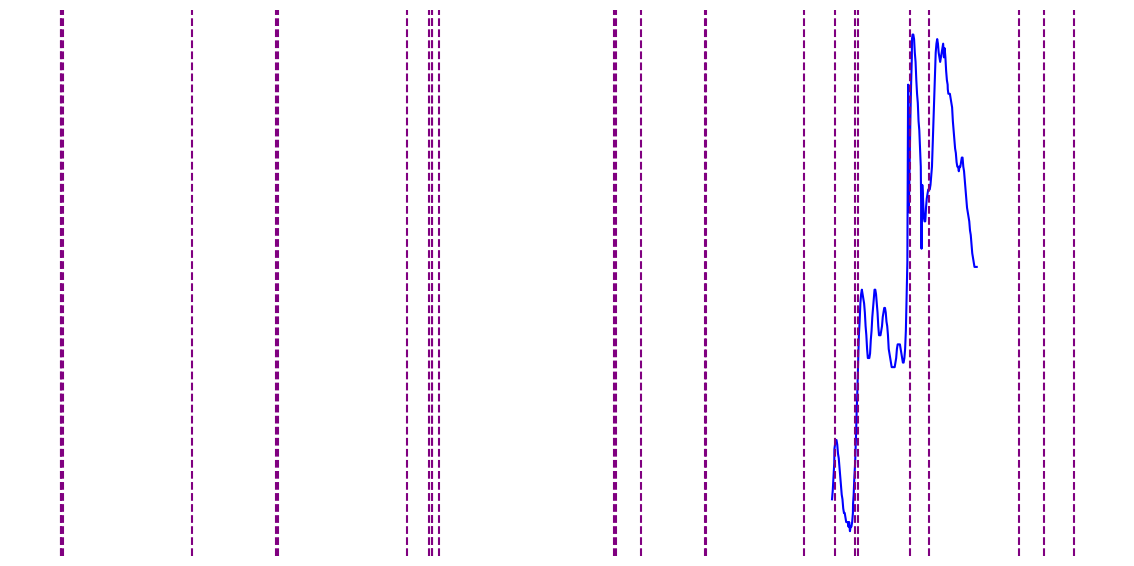

In [180]:
# Patient and Prediction Data
prediction_horizon = 6
patient = '001'

food_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

# Convert datetime to pandas datetime
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

approaches = ['gpt4o', 'sonnet', 'llava', 'nollm']

approach = 'nollm'
nollm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_preds.csv")
approach = 'gpt4o'
llm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_preds.csv")

start_idx =1000
selected_idx = list(range(start_idx, start_idx + 200))
llm_preds = llm_preds.iloc[selected_idx, :]
nollm_preds = nollm_preds.iloc[selected_idx, :]

nollm_preds['Datetime'] = pd.to_datetime(nollm_preds['Datetime'])

plt.figure(figsize=(12, 6))

# Plot Ground Truth
plt.plot(nollm_preds['Datetime'],  nollm_preds['Initial_glucose'] - nollm_preds['Ground_truth'], label='Ground Truth', color='blue')


# Add vertical lines for meal times
for idx, meal_time in food_data.iterrows():
        plt.axvline(x=meal_time['datetime'], color='purple', linestyle='--')

# Add dummy plots to include in the legend
plt.plot([], [], color='purple', linestyle='--', label='Meal')


plt.ylabel('Glucose Level')
plt.tight_layout()
plt.axis('off')
plt.show()



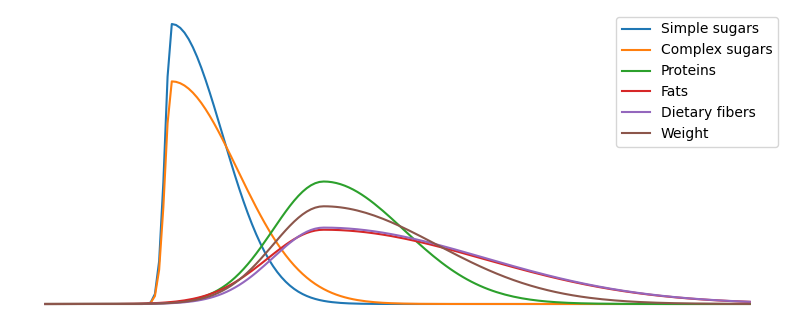

In [62]:
feature_params = {
    'Simple sugars': [30, 0.5, 0.5],
    'Complex sugars': [30, 0.3, 0.5],
    'Proteins': [0.5, 0.2, 3.5],
    'Fats': [0.4, 0.05, 3.5], 
    'Dietary fibers': [0.5, 0.05, 3.5],
    'Weight': [0.5, 0.1, 3.5], 
}

times = np.arange(6, 20, (1/12))
intake_time = 8

glucose_data = pd.DataFrame({'Time': times})

for feature, param in feature_params.items():
    time_diff_hours = times - intake_time - param[2]
    weights = np.where(time_diff_hours < 0,
                       np.exp(-param[0] * time_diff_hours ** 2),
                       np.exp(-param[1] * time_diff_hours ** 2))
    weights = weights / np.sum(weights)
    glucose_data[feature] = weights

plt.figure(figsize=(10, 4))
for feature in feature_params.keys():
    plt.plot(glucose_data['Time'], glucose_data[feature], linestyle='-', label=feature)

plt.axis('off')
plt.legend()
plt.show()

In [63]:
food_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')

insulin_data = pd.read_csv(f"food_data/gpt4o/{patient}.csv")
insulin_data['datetime'] = pd.to_datetime(insulin_data['datetime'], format='%Y:%m:%d %H:%M:%S')


# Convert datetime to pandas datetime
food_data['datetime'] = pd.to_datetime(food_data['datetime'], format='%Y:%m:%d %H:%M:%S')
insulin_data['datetime'] = pd.to_datetime(insulin_data['datetime'], format='%Y:%m:%d %H:%M:%S')

# Patient and Prediction Data
prediction_horizon = 12
patient = '001'
approaches = ['gpt4o', 'sonnet', 'llava', 'nollm']

approach = 'gpt4o'
llm_preds = pd.read_csv(f"predictions/{approach}/{prediction_horizon}/{patient}_preds.csv")

start_idx =1000
selected_idx = list(range(start_idx, start_idx + 200))
llm_preds = llm_preds.iloc[selected_idx, :]

llm_preds['Datetime'] = pd.to_datetime(llm_preds['Datetime'])

plt.figure(figsize=(12, 3))

# Plot Ground Truth
plt.plot(nollm_preds['Datetime'],  nollm_preds['Initial_glucose'] - nollm_preds['Ground_truth'], label='Ground Truth', color='blue')

# Plot Predictions
plt.plot(llm_preds['Datetime'],  llm_preds['Initial_glucose'] - llm_preds['Predictions'], label='Prediction', color='green')

# Add vertical lines for meal times
for idx, meal_time in food_data.iterrows():
    if nollm_preds['Datetime'].iloc[0] <= meal_time['datetime'] <= nollm_preds['Datetime'].iloc[-1]:
        plt.axvline(x=meal_time['datetime'], color='purple', linestyle='--')

# Add dummy plots to include in the legend
plt.plot([], [], color='purple', linestyle='--', label='Meal')

plt.axis('off')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'food_data/gpt4o/1.csv'

Intercept -15.02830016097019
Prediction_local [31.65260435]
Right: 75.46305674060225


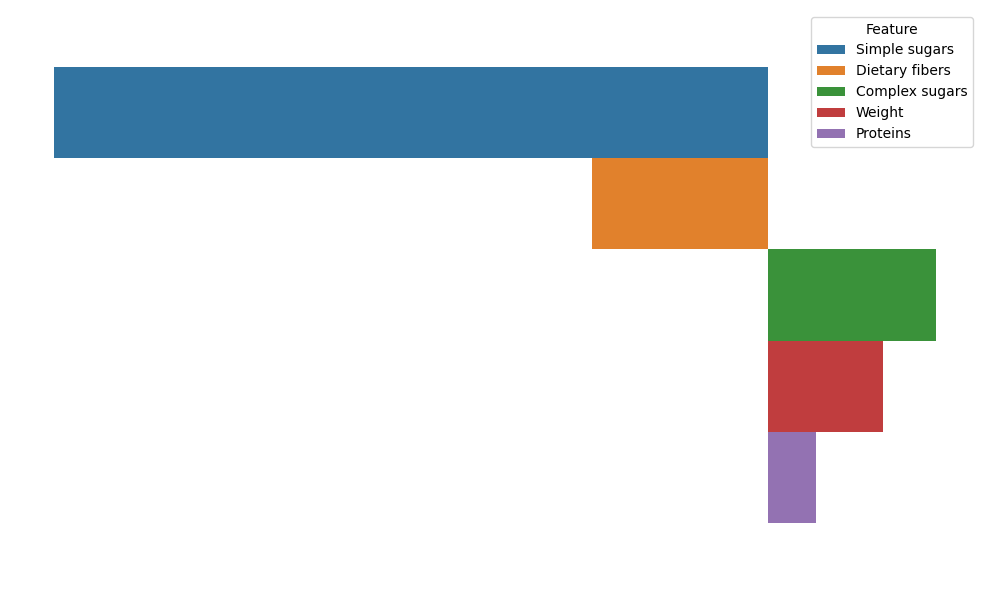

In [83]:
data = pd.read_csv("data/sonnet/12/data.csv")  
X = data.drop(['glucose_next', 'datetime', 'patient', 'hour'], axis=1)  
prediction_horizon = 12  
approach = 'sonnet'  
patient = '001'   
model_path = f"models/{approach}/{prediction_horizon}/lightgbm_model_{patient}.joblib"  
model = joblib.load(model_path)  
explainer = LimeTabularExplainer(X.values,   
                                 feature_names=X.columns,   
                                 class_names=['glucose_next'],   
                                 verbose=True,   
                                 mode='regression')  
  

def predict_fn(data):  
    return model.predict(data)  
instance_idx = np.argmax(data['glucose_next'])
instance = X.iloc[instance_idx].values.reshape(1, -1)  
exp = explainer.explain_instance(instance[0], predict_fn, num_features=len(X.columns))   
feature_importances = exp.as_list()  
  
# Convert to DataFrame  
importance_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])  

importance_df.drop([0,2,3,5,7,9,10,12,13,14], inplace=True)
importance_df['Feature'] = ['Simple sugars', 'Dietary fibers', 'Complex sugars', 'Weight', 'Proteins']
plt.figure(figsize=(10, 6))  
sns.barplot(x='Importance', hue='Feature', data=importance_df)  
plt.axis('off') 
plt.tight_layout()  
plt.show()  